# This is the submission Notebook of Team Sigmoid Freud
by Qianjing, Daniel, Jacob, Fan, Jan

## Download the data, import necessary packages and load the data into DataFrames

In [1]:
# Demonstration data used in this excercise is already preprocessed and split into
# training, validation, and test sets

# Use wget to download the data stored in csv format.
import itertools

# Define what files to download; download all of the preprocessed data
# Note that the data are already split into Train, Validation, and Test sets.
# The predictor data are denoted with 'X', the target by 'y'
data_download = {}
data_download["window_size"] = [5, 15]
data_download["data_type"] = ["train", "valid", "test"]
data_download["predictor_or_target"] = ["X", "y"]

# Prepare the combinations of the window sizes and the data types
keys, values = zip(*data_download.items())
data_download_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
display('The kind of data to be downloaded:', data_download_combinations)

print("Downloading started...")
for data_download_param in data_download_combinations:
  file_to_download = "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_{0}_time_encoding_True/{1}_{2}_window_size_{0}_time_encoding_True.csv"\
                     .format(data_download_param["window_size"], data_download_param["predictor_or_target"], data_download_param["data_type"])

  # the actual downloading
  !wget "$file_to_download"

print("Downloading has finished")

'The kind of data to be downloaded:'

[{'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 5},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 5},
 {'data_type': 'train', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'train', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'valid', 'predictor_or_target': 'y', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'X', 'window_size': 15},
 {'data_type': 'test', 'predictor_or_target': 'y', 'window_size': 15}]

--2021-11-01 21:31:43--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/X_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)... 52.219.47.124
Connecting to frankfurt-school-dataset.s3.eu-central-1.amazonaws.com (frankfurt-school-dataset.s3.eu-central-1.amazonaws.com)|52.219.47.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53997719 (51M) [text/csv]
Saving to: ‘X_train_window_size_5_time_encoding_True.csv’

X_train_window_size 100%[===================>]  51.50M  20.7MB/s    in 2.5s    

2021-11-01 21:31:46 (20.7 MB/s) - ‘X_train_window_size_5_time_encoding_True.csv’ saved [53997719/53997719]

--2021-11-01 21:31:46--  https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_5_time_encoding_True/y_train_window_size_5_time_encoding_True.csv
Resolving frankfurt-sch

In [2]:
pip install catboost

     |████████████████████████████████| 76.3 MB 16 kB/s 


In [3]:
#This imports all necessary packages for our tasks
import pandas as pd
import numpy as np

#Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#Import necessary ml packages
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor 
import lightgbm as lgb

#Import necessary Deep Learning
import tensorflow as tf
import tensorflow.keras as k 
from tensorflow.keras.layers import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Import the dataset with a sliding window of 15
X_train_window_size_15 = pd.read_csv('X_train_window_size_15_time_encoding_True.csv')
X_valid_window_size_15 = pd.read_csv('X_valid_window_size_15_time_encoding_True.csv')
X_test_window_size_15 = pd.read_csv('X_test_window_size_15_time_encoding_True.csv')
y_train_window_size_15 = pd.read_csv('y_train_window_size_15_time_encoding_True.csv')
y_valid_window_size_15 = pd.read_csv('y_valid_window_size_15_time_encoding_True.csv')
y_test_window_size_15 = pd.read_csv('y_test_window_size_15_time_encoding_True.csv')

# Exploratory Data Analysis (EDA)

## Helper functions for plotting

In [ ]:
#First create our helper models to plot our analysis
def plot_subplots(dataframe: pd.DataFrame, title: str):
    """
    Draws one subplot for each of the columns in the DataFrame.
    """
    
    fig, axes = plt.subplots(nrows=len(dataframe.columns), figsize=(20,20))
    labels = list(dataframe.columns)

    for idx, row in enumerate(axes):
        y = dataframe.iloc[:, idx]
        row.plot(y, label=y.name)
        row.set_ylabel(labels[idx])

    fig.set_facecolor("grey")
    fig.suptitle(title, size=15, y=0.9)
    plt.show()

In [ ]:
def plot_subplots_wrapper(
    dataframe: pd.DataFrame,
    title: str,
    labels: list = ["open", "high", "low", "close", "volume", "minutes"]
    ):
    """
    Calls the 'plot_subplots' function for each label provided in labels and selects columns that start with the label.
    """

    #df = dataframe.copy()
    for label in labels:
        print(f"Plots for {label}:")
        title = title + f" {label}"
        plot_subplots(dataframe.loc[:,dataframe.columns.str.startswith(label)], title)

### Get a basic understanding of the data

In [ ]:
#Starting with our basic analysis for our data with a sliding winwow of 15
X_train_window_size_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29888 entries, 0 to 29887
Columns: 101 entries, total_hours to 83
dtypes: float64(101)
memory usage: 23.0 MB


In [5]:
#Lets renae our columns so we actually understand columns with name 1 - 23
def rename_time_series(df):
    labels = ["open", "high", "low", "close", "volume", "minutes"]
    new_cols = list(df.columns[:17])
    for i in range(14, 0, -1):
        for label in labels:
            new_cols.append(label+f"_{i}_{i-1}")

    df_original = df.copy()
    df.columns = new_cols

    return df

In [6]:
X_train_window_size_15 = rename_time_series(X_train_window_size_15)
X_valid_window_size_15 = rename_time_series(X_valid_window_size_15)
X_test_window_size_15 = rename_time_series(X_test_window_size_15)

In [ ]:
X_train_window_size_15.info()

In [ ]:
X_train_window_size_15.head(5)

total_hours  dlvry_weekend  ...  volume_1_0  minutes_1_0
0    16.367966            0.0  ...       890.7        180.0
1    17.549852            0.0  ...       107.5        240.0
2    17.549852            0.0  ...      1169.5        180.0
3    19.078845            0.0  ...       321.4        360.0
4    19.078845            0.0  ...       -79.6        300.0

[5 rows x 101 columns]

## This plots how many rows per contarct are and aggregates them

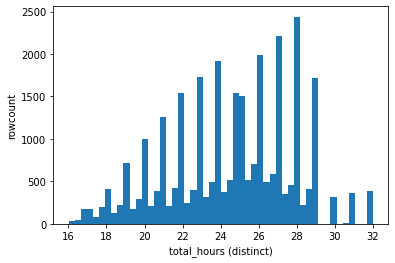

In [ ]:
#This distribution show how many rows
X_train_window_size_15_grouped = X_train_window_size_15.groupby("total_hours").size().reset_index()
X_train_window_size_15_grouped.rename(columns={0: "rowcount"}, inplace=True)

plt.hist(X_train_window_size_15["total_hours"], label="rowcount", bins=50)
plt.xlabel("total_hours (distinct)")
plt.ylabel("rowcount")
plt.show()

## Candle Features 

Plots for open:


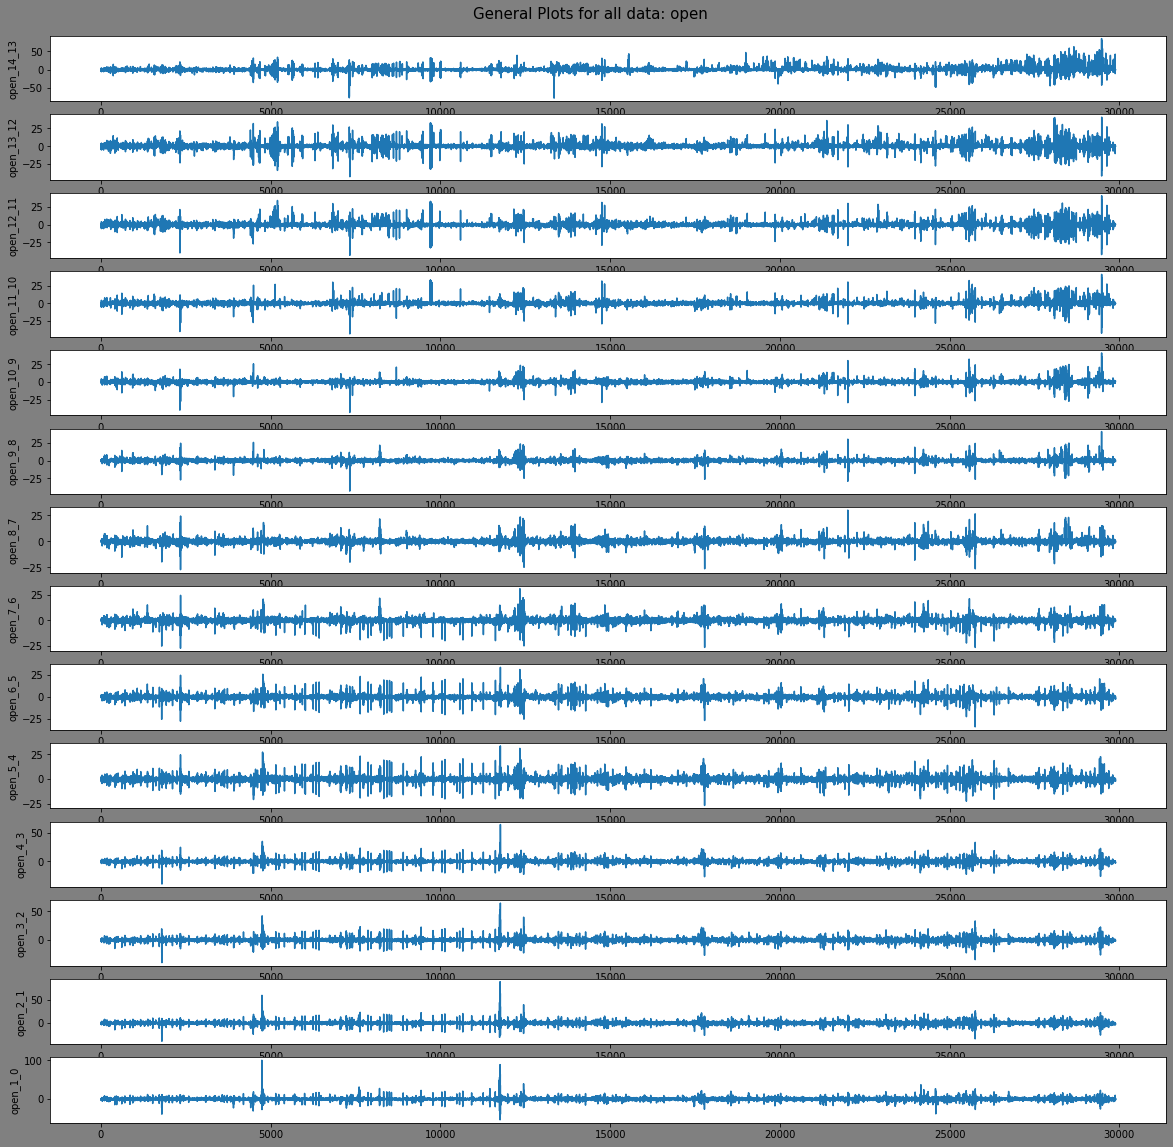

Plots for high:


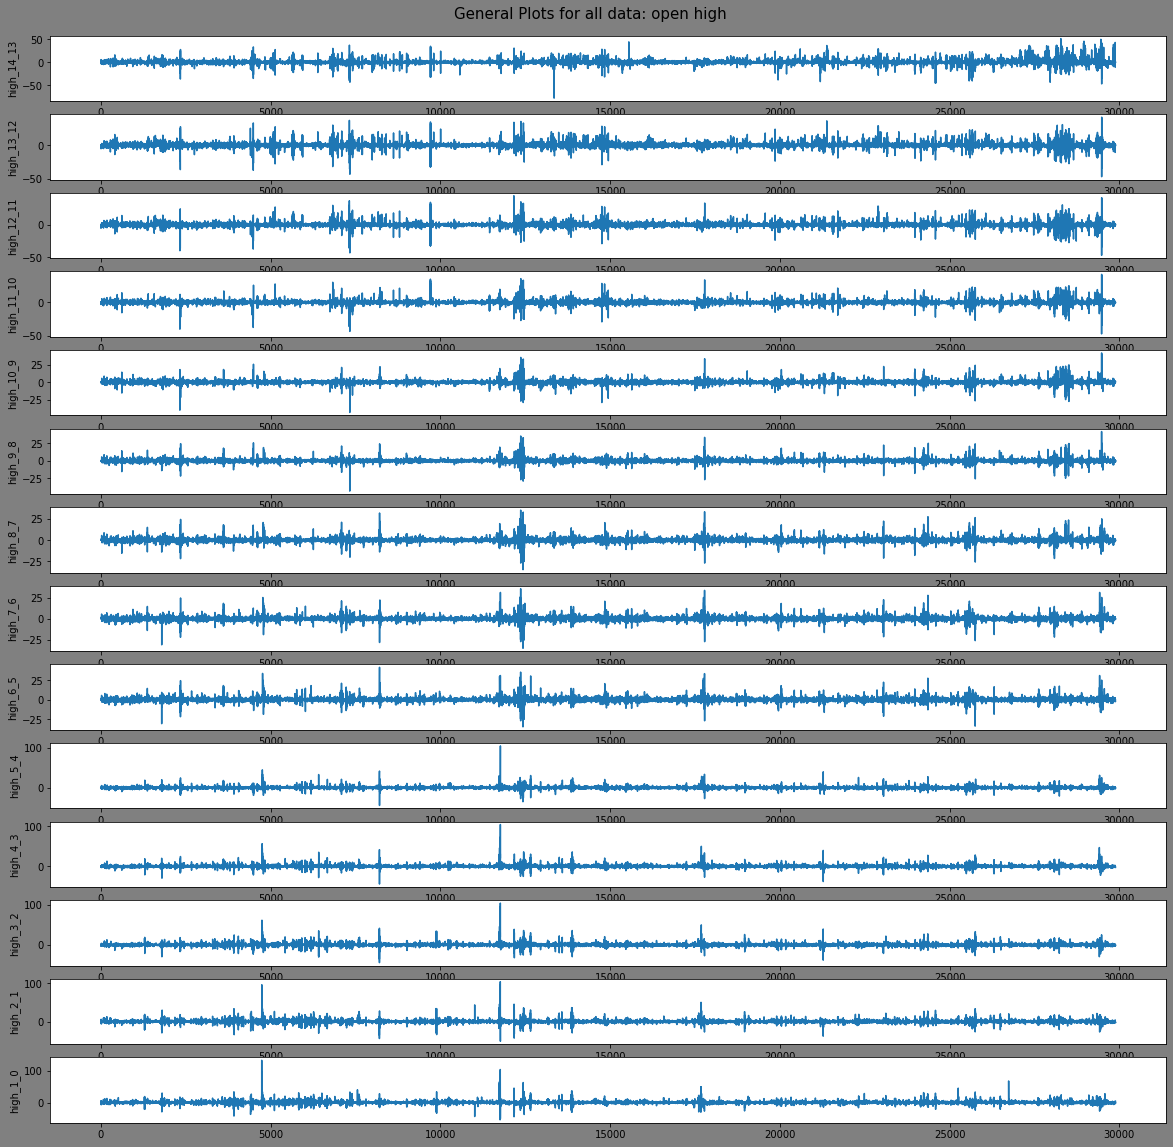

Plots for low:


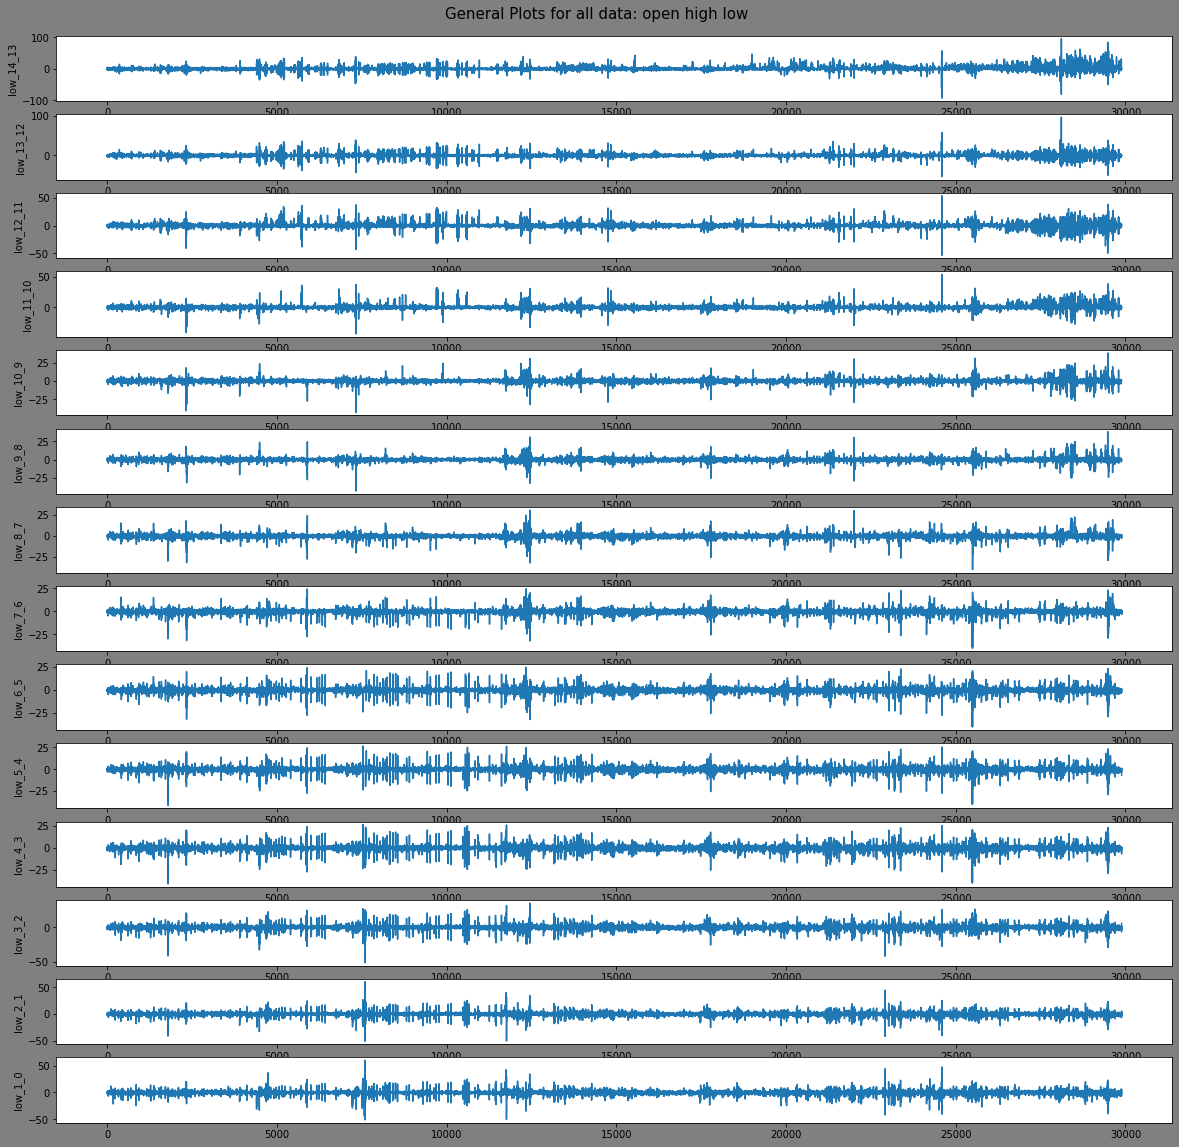

Plots for close:


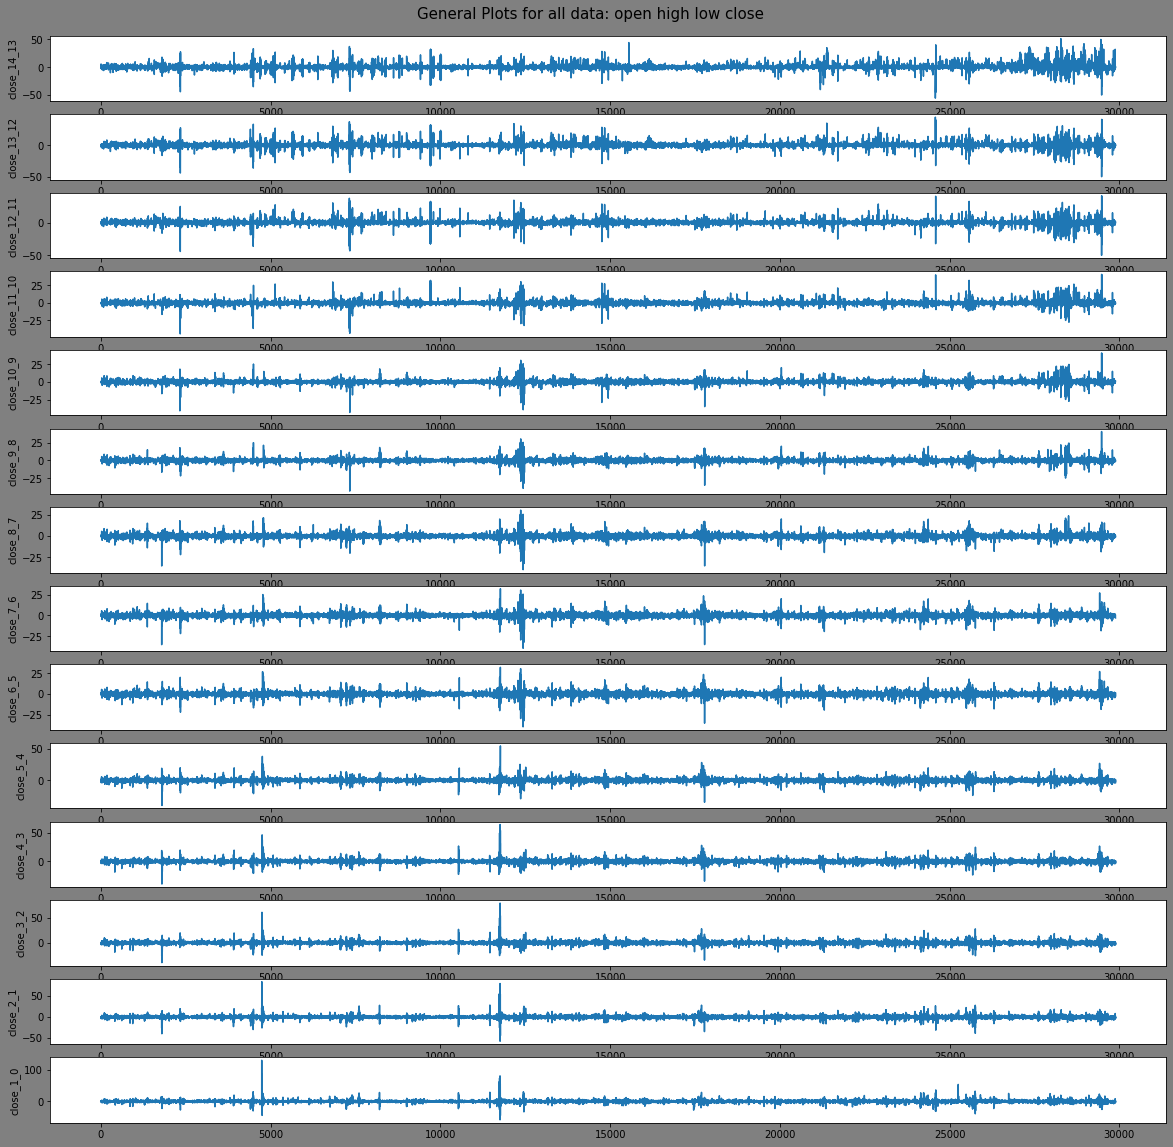

Plots for volume:


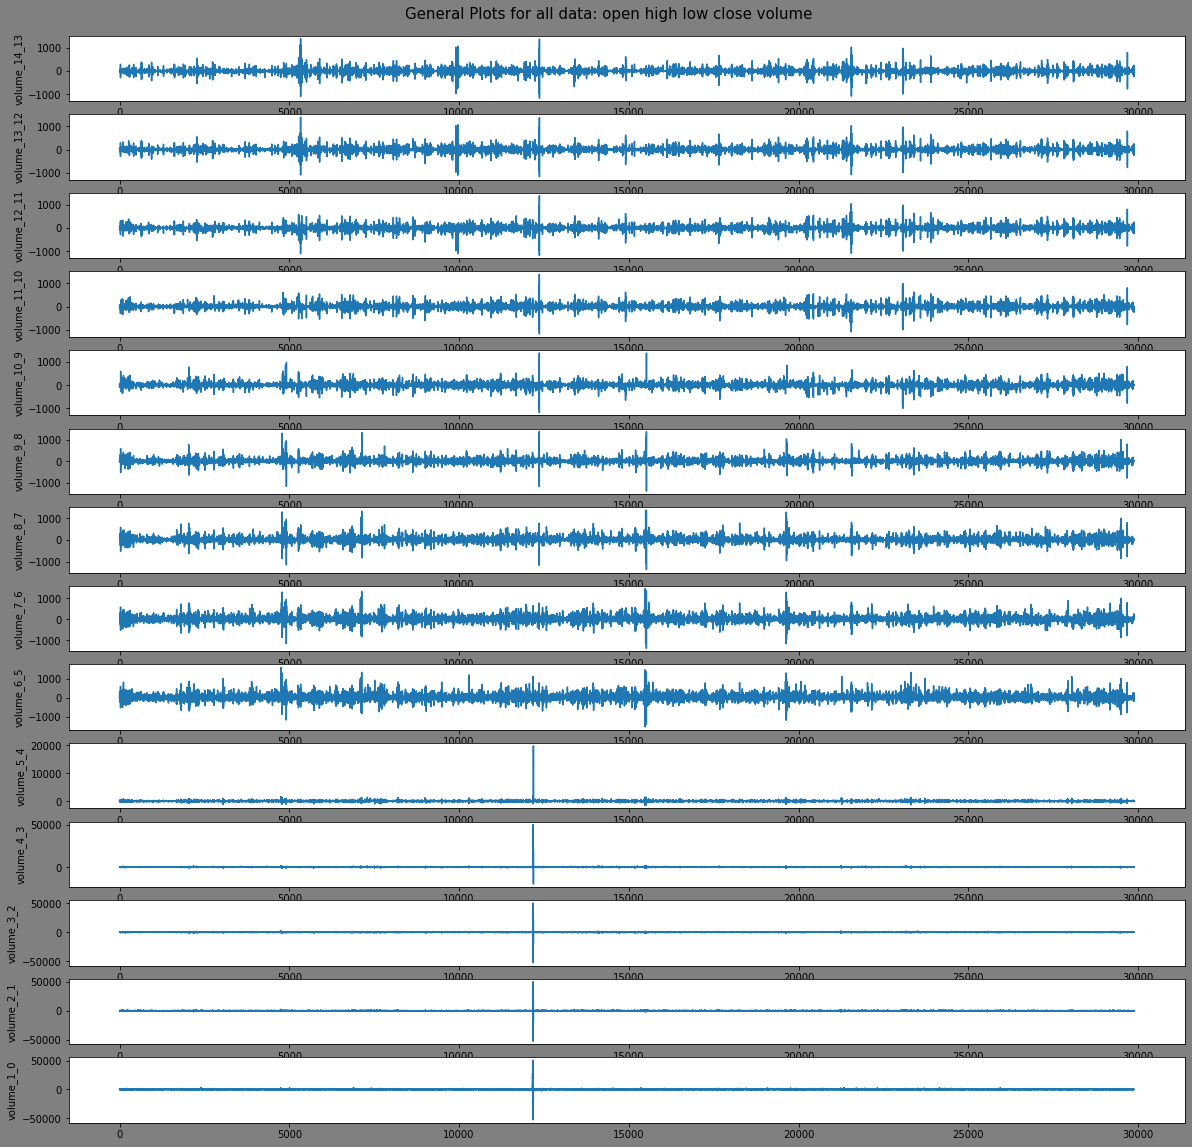

Plots for minutes:


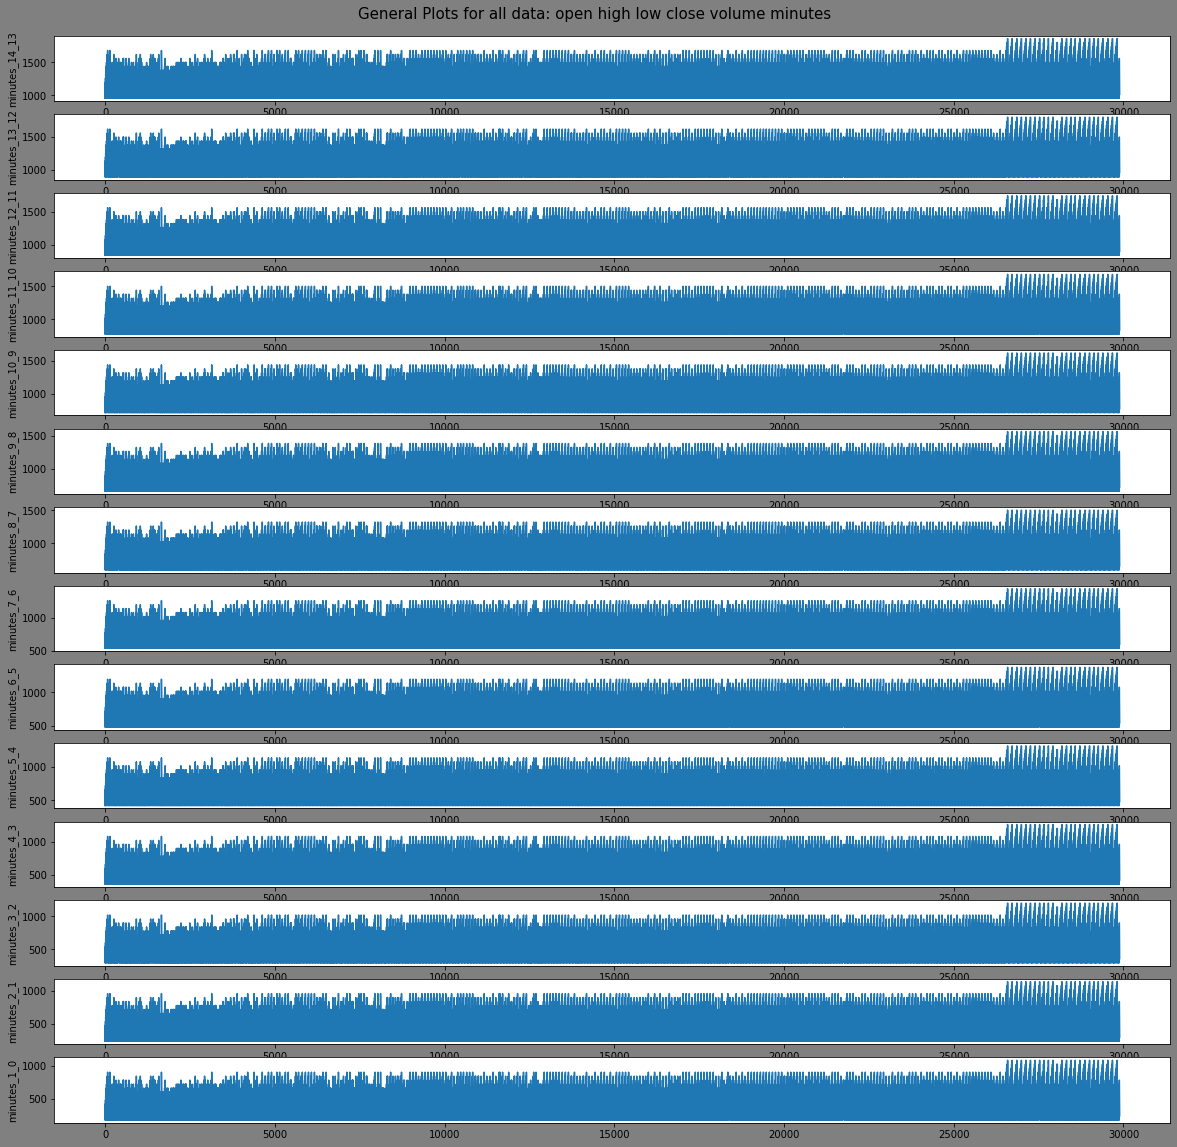

In [ ]:
df_to_plot = X_train_window_size_15.copy()
title = "General Plots for all data:"
plot_subplots_wrapper(df_to_plot, title)

Plots for open:


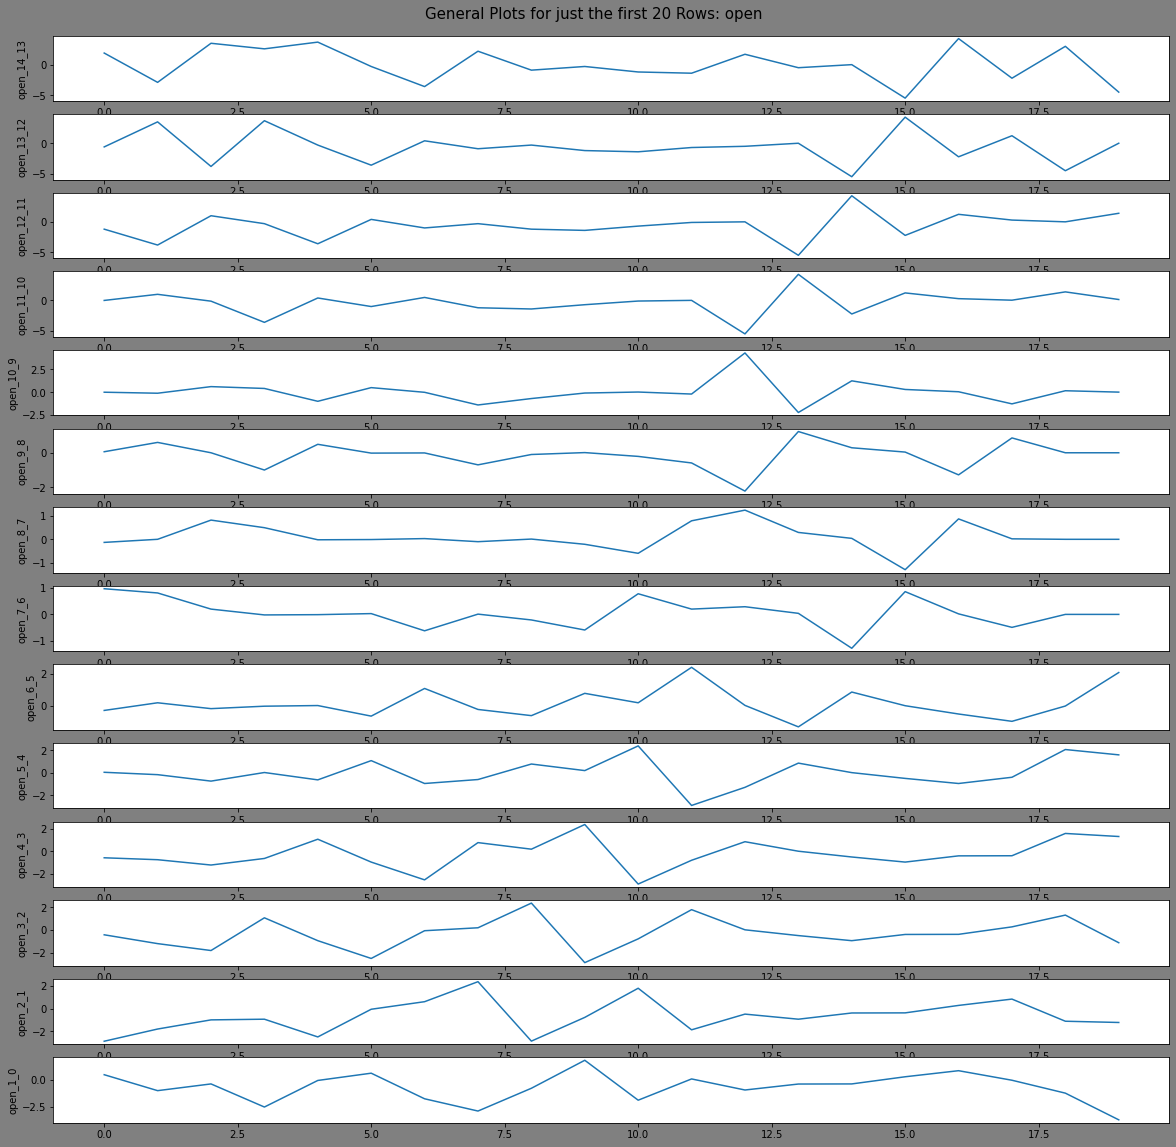

Plots for high:


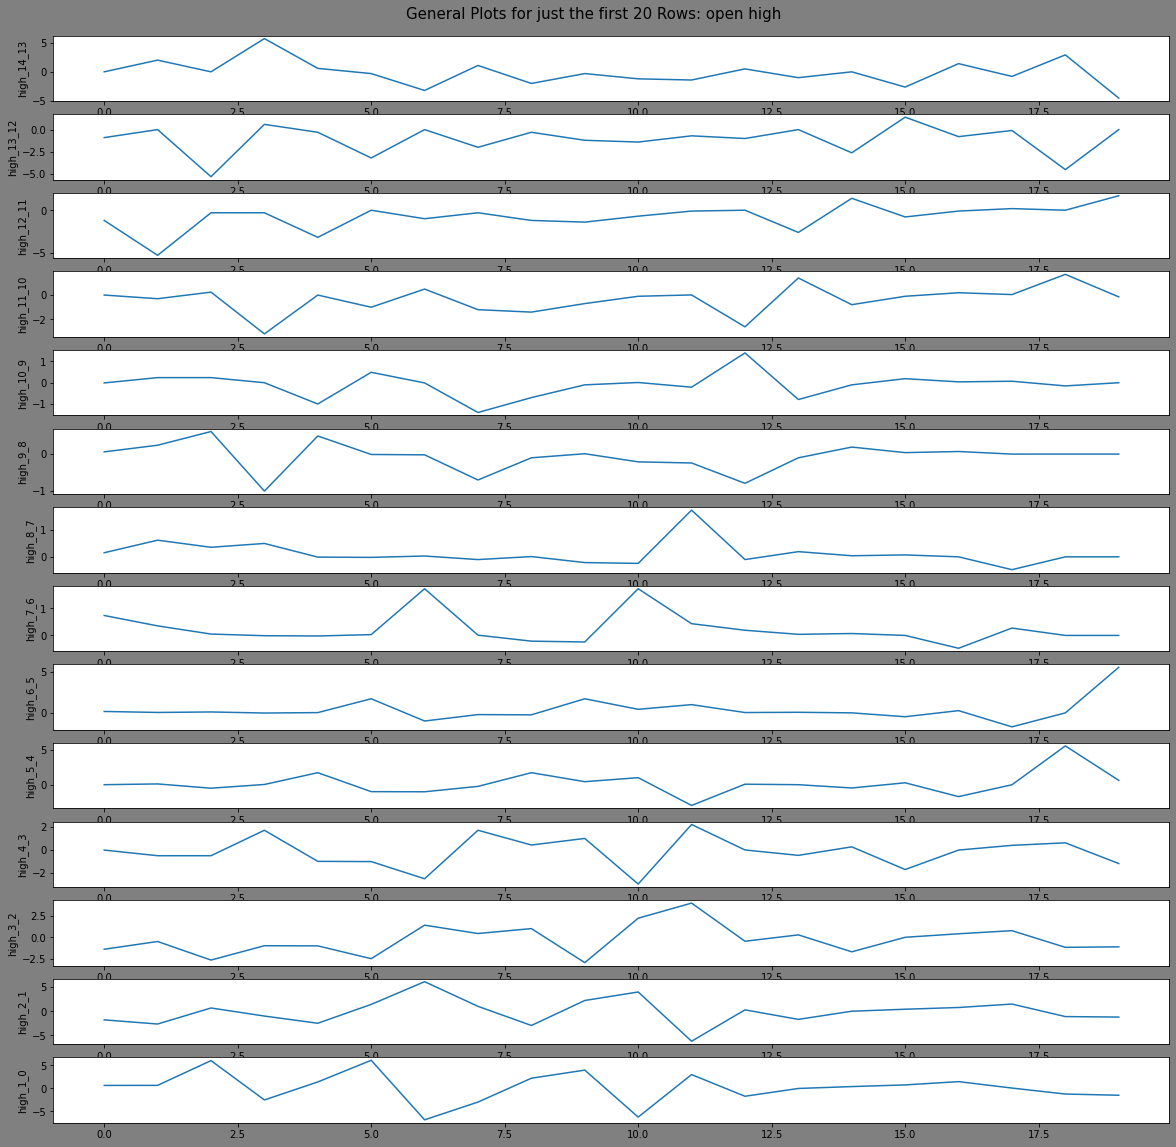

Plots for low:


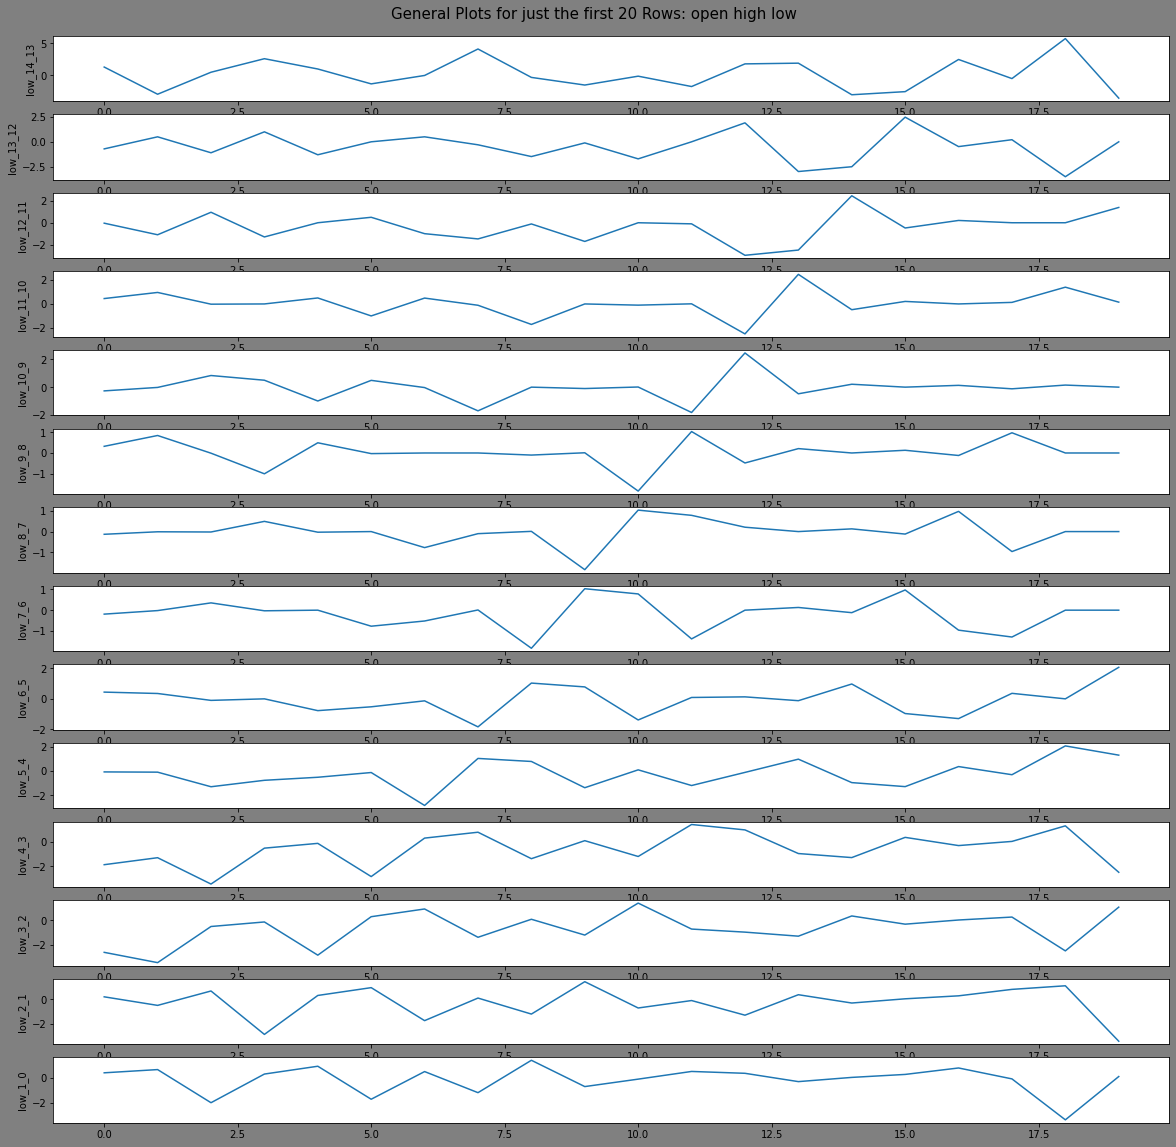

Plots for close:


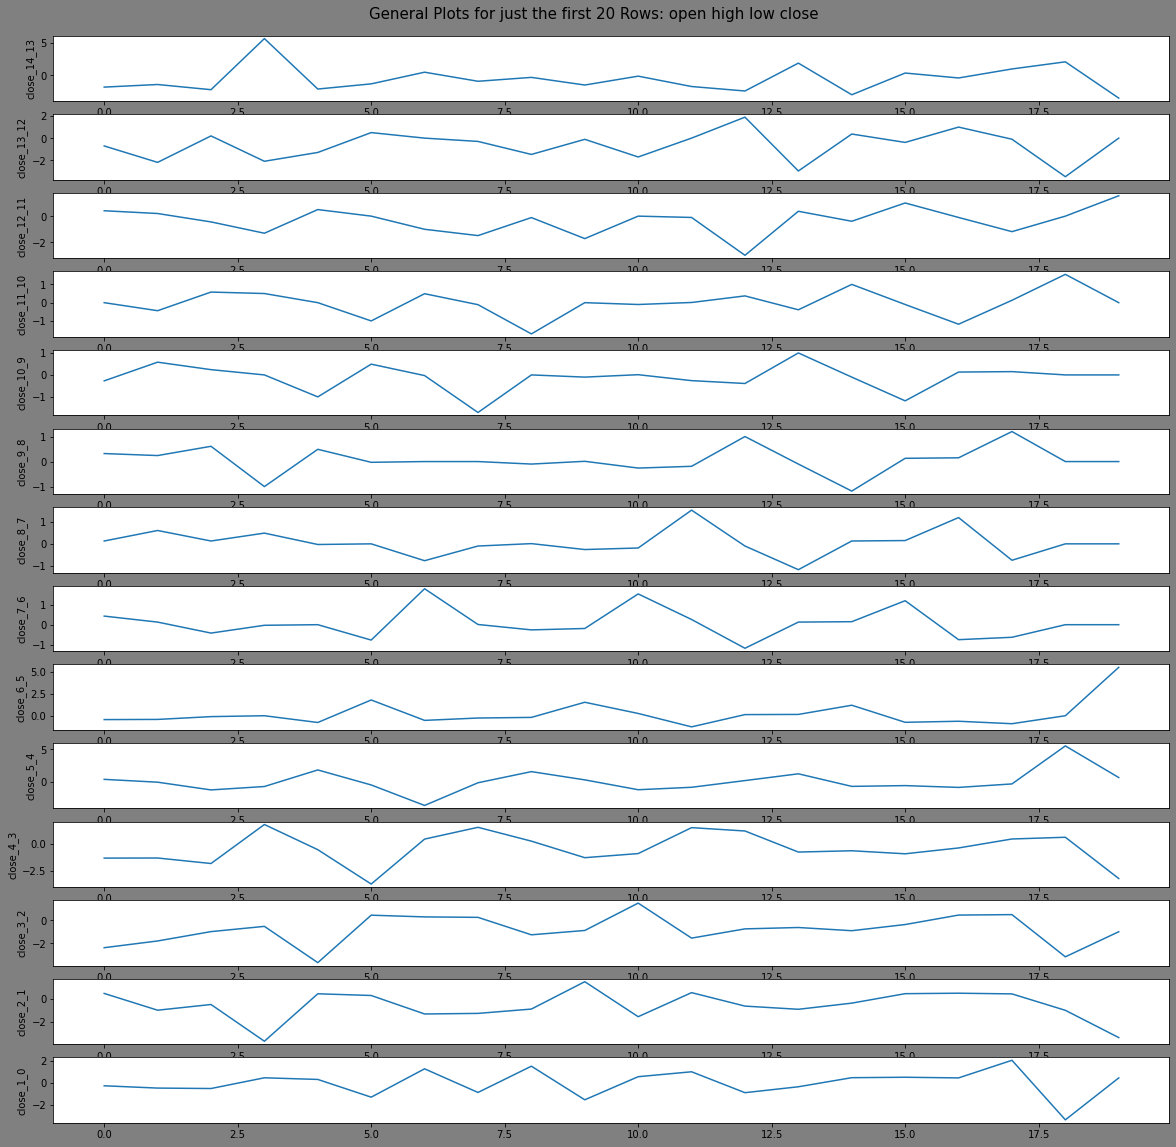

Plots for volume:


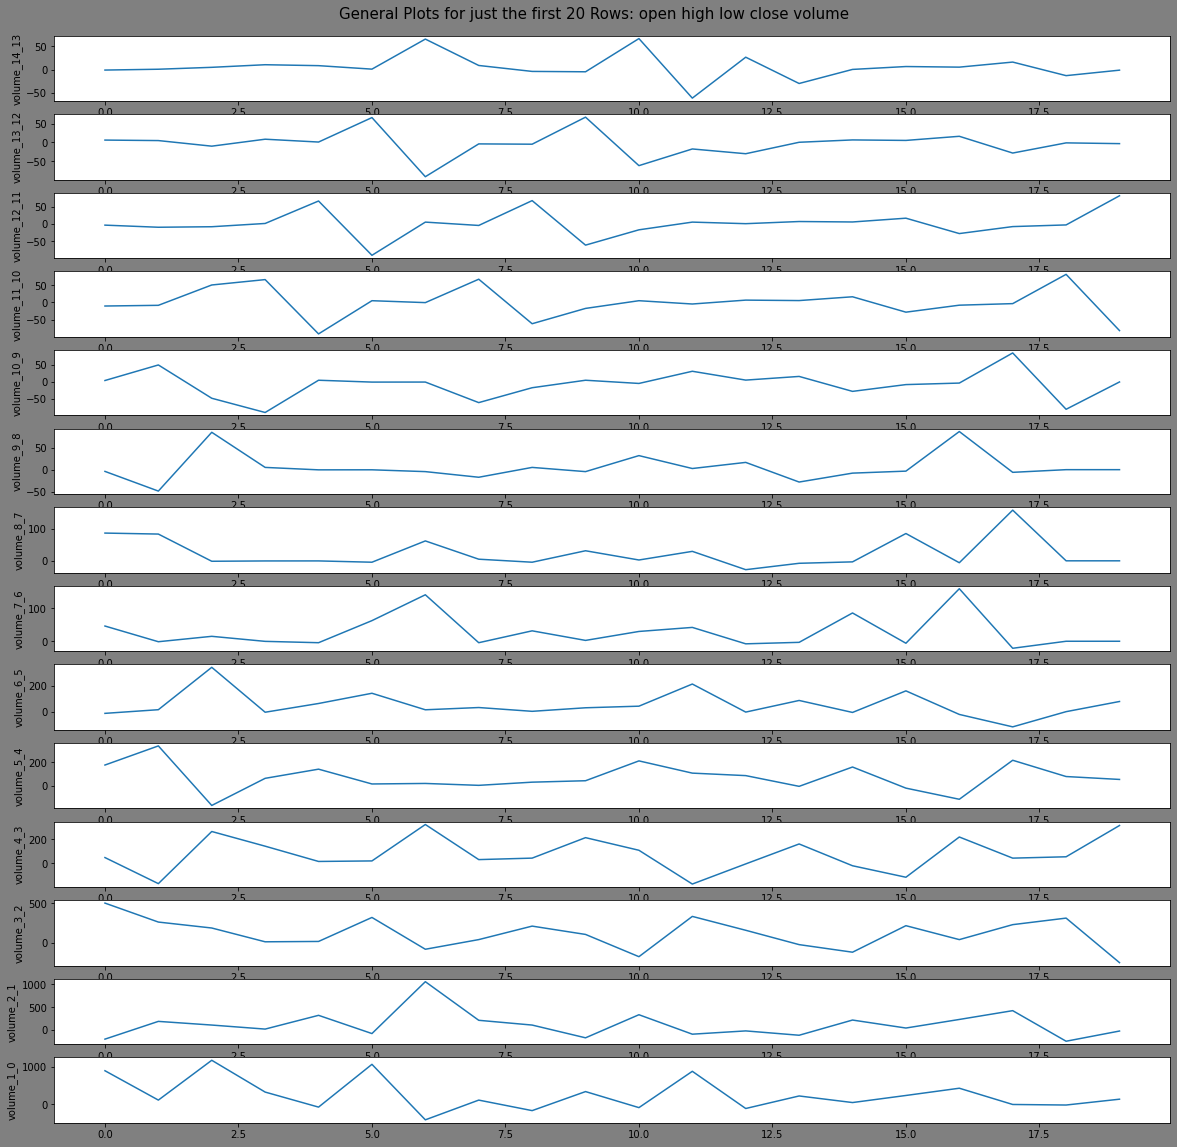

Plots for minutes:


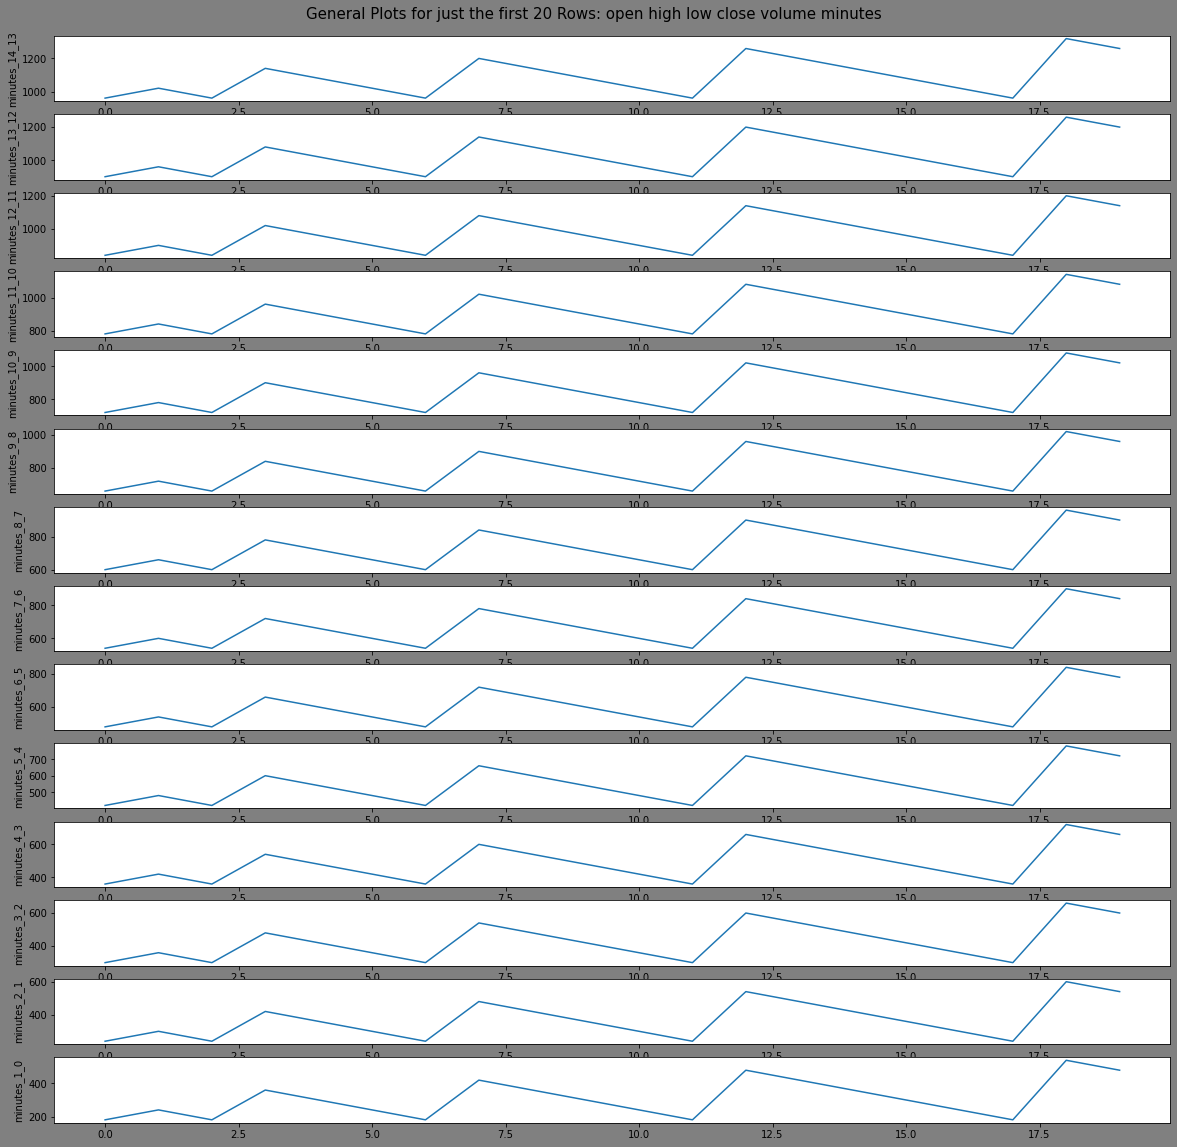

In [ ]:
df_to_plot = X_train_window_size_15.copy()
title = "General Plots for just the first 20 Rows:"
plot_subplots_wrapper(df_to_plot.iloc[:20, :].reset_index(), title)

## Correlation

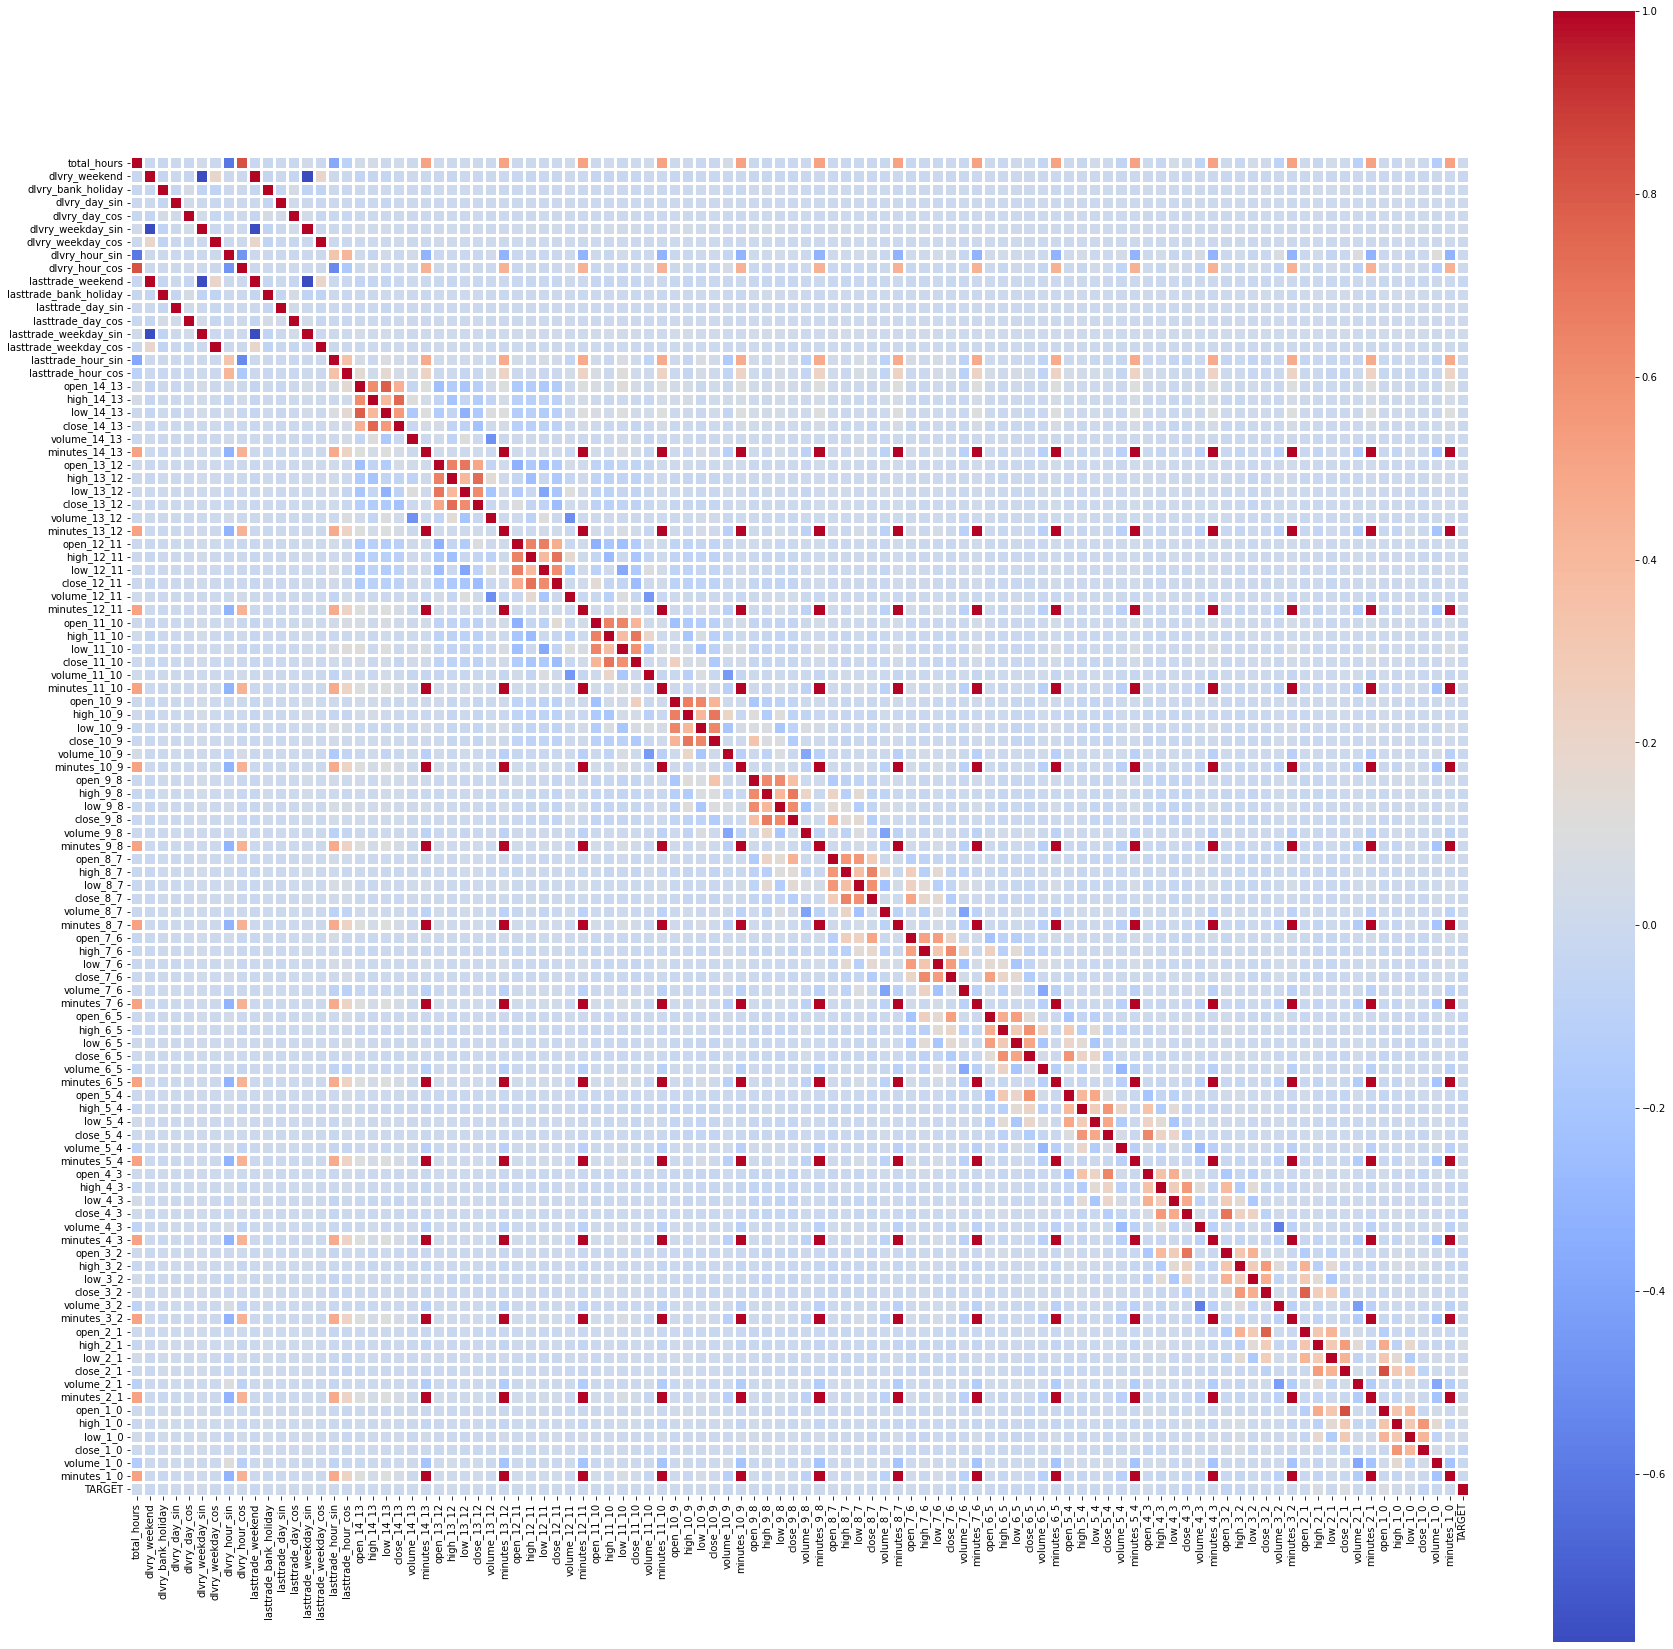

In [ ]:
plt.figure(figsize=(30,30))
full_train_window_size_15 = X_train_window_size_15.copy()
full_train_window_size_15["TARGET"] = y_train_window_size_15["y"]
sns.heatmap(full_train_window_size_15.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

### The summary of the correlation matrix

# Creating Machine Learning models

## Preprocessing the data

### Make data tree-friendly: sin/cos features retransformation to make them work for tree-based approaches

Tree-based algorithms like Random Forest and Boosted Trees build their split rules according to one feature at a time. The cosine-sine transformation of features created 2 columns for every cyclical feature. If possible, we should retransform these 2 features to the original values to increase the chance of higher accuracy of the tree-based approaches.

There are 6 features (i.e., dlvry_day, dlvry_weekday, dlvry_hour, lasttrade_day, lasttrade_weekday, lasttrade_hour) encoded using a sine and cosine column respectively.

As one cannot simply solve the underlying sine and cosine transformations to the original value, we tried to reproduce the tranaformation in order to get the original values.

#### _weekday features

When we look at the values for the dlvry_weekday, we can see that there are 7 unique values, corresponding to the days of the week.

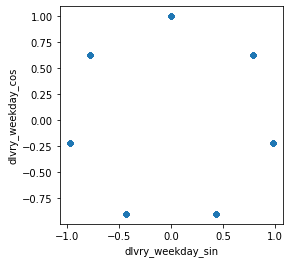

In [ ]:
# plot sample of values
X_train_window_size_15.sample(500).plot.scatter('dlvry_weekday_sin','dlvry_weekday_cos').set_aspect('equal')

In [ ]:
# look at unique values
X_train_window_size_15.groupby(['dlvry_weekday_sin', 'dlvry_weekday_cos']).size().reset_index().rename(columns={0:'count'})

dlvry_weekday_sin  dlvry_weekday_cos  count
0          -0.974928          -0.222521   4193
1          -0.781831           0.623490   4193
2          -0.433884          -0.900969   4278
3           0.000000           1.000000   4208
4           0.433884          -0.900969   4376
5           0.781831           0.623490   4189
6           0.974928          -0.222521   4451

With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for days of the week.

In [7]:
days_in_a_week = 7

mapping_day_of_week = {}

# apply cosine and sine transformaiton for every day of the week
for i in range(0, days_in_a_week):
  mapping_day_of_week[(round(np.sin(2*np.pi*i/days_in_a_week), 5), round(np.cos(2*np.pi*i/days_in_a_week), 5))] = i

mapping_day_of_week

{(-0.97493, -0.22252): 5,
 (-0.78183, 0.62349): 6,
 (-0.43388, -0.90097): 4,
 (0.0, 1.0): 0,
 (0.43388, -0.90097): 3,
 (0.78183, 0.62349): 1,
 (0.97493, -0.22252): 2}

In [8]:
# create function to convert sine- and cosine-transformed values back
def convert_weekday(sin, cos):
  """Return original value from sine- and cosine-transformed values
  
  Arguments:
  sin -- sine-transformed value
  cos -- cosine-transformed value"""
  weekday = mapping_day_of_week[(round(sin, 5), round(cos, 5))]
  return weekday

#### _hour features

When we look at the values for the dlvry_hour, we can see that there are most likely 24 possible values (points are distributed like a 24h clock, corresponding to the hours of the day.

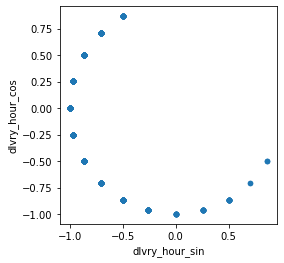

In [9]:
# plot sample of values
X_train_window_size_15.sample(500).plot.scatter('dlvry_hour_sin','dlvry_hour_cos').set_aspect('equal')

In [10]:
# look at unique values
hours = X_train_window_size_15.groupby(['lasttrade_hour_sin','lasttrade_hour_cos']).size().reset_index().rename(columns={0:'count'})
hours[["lasttrade_hour_sin", "lasttrade_hour_cos"]].round(5)

lasttrade_hour_sin  lasttrade_hour_cos
0             -1.00000            -0.00000
1             -0.96593            -0.25882
2             -0.96593             0.25882
3             -0.86603            -0.50000
4             -0.70711            -0.70711
5             -0.50000            -0.86603
6             -0.25882            -0.96593
7              0.00000            -1.00000
8              0.25882            -0.96593
9              0.50000            -0.86603
10             0.70711             0.70711
11             0.70711            -0.70711
12             0.86603             0.50000
13             0.86603            -0.50000
14             0.96593            -0.25882
15             0.96593             0.25882
16             1.00000             0.00000

With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for hours of the day.

In [11]:
hours_in_a_day = 24

mapping_hour_of_day = {}

# apply cosine and sine transformaiton for every hour of the day
for i in range(0, hours_in_a_day):
  mapping_hour_of_day[(round(np.sin(2*np.pi*i/hours_in_a_day), 5), round(np.cos(2*np.pi*i/hours_in_a_day), 5))] = i
                            
mapping_hour_of_day    

{(-1.0, -0.0): 18,
 (-0.96593, -0.25882): 17,
 (-0.96593, 0.25882): 19,
 (-0.86603, -0.5): 16,
 (-0.86603, 0.5): 20,
 (-0.70711, -0.70711): 15,
 (-0.70711, 0.70711): 21,
 (-0.5, -0.86603): 14,
 (-0.5, 0.86603): 22,
 (-0.25882, -0.96593): 13,
 (-0.25882, 0.96593): 23,
 (0.0, -1.0): 12,
 (0.0, 1.0): 0,
 (0.25882, -0.96593): 11,
 (0.25882, 0.96593): 1,
 (0.5, -0.86603): 10,
 (0.5, 0.86603): 2,
 (0.70711, -0.70711): 9,
 (0.70711, 0.70711): 3,
 (0.86603, -0.5): 8,
 (0.86603, 0.5): 4,
 (0.96593, -0.25882): 7,
 (0.96593, 0.25882): 5,
 (1.0, 0.0): 6}

In [12]:
# create function to convert sine- and cosine-transformed values back
def convert_hour(sin, cos):
  hour = mapping_hour_of_day[(round(sin, 5), round(cos, 5))]
  return hour

#### _day features

When we look at the values for the dlvry_day, we can see that there is no obvious patterns like we observed for the _hour and _weekday features.

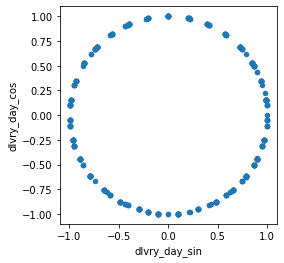

In [13]:
# plot sample of values
X_train_window_size_15.sample(500).plot.scatter('dlvry_day_sin','dlvry_day_cos').set_aspect('equal')

In [14]:
# look at unique values
year_days = X_train_window_size_15.groupby(['dlvry_day_sin','dlvry_day_cos']).size().reset_index().rename(columns={0:'count'})
year_days = year_days[['dlvry_day_sin','dlvry_day_cos']].round(5)
year_days

dlvry_day_sin  dlvry_day_cos
0        -0.99872       -0.05065
1        -0.99452        0.10453
2        -0.99452       -0.10453
3        -0.98847        0.15143
4        -0.96808       -0.25065
..            ...            ...
77        0.98847        0.15143
78        0.99452        0.10453
79        0.99452       -0.10453
80        0.99872       -0.05065
81        1.00000        0.00000

[82 rows x 2 columns]

Intuitively, we might assume that the transformation is based on 365 days in a year, but creating the respective mapping does not yield matches (see below), so we couldn't reproduce the sine and cosine features for the _day features.

In [15]:
days_in_a_year = 365

mapping_day = {}

for i in range(0, days_in_a_year):
  mapping_day[(round(np.sin(2*np.pi*i/days_in_a_year), 5), round(np.cos(2*np.pi*i/days_in_a_year), 5))] = i

# check whether there is a match with randomly picked values from the unique values above
try: 
  mapping_day[(0.98847, 0.15143)]
except KeyError:
  print("There is no match")

There is no match


#### transformation

In [ ]:
def tree_transform(data, drop_day=True):
  """Return tree-friendly data with cos and sin features transformed back to original values
  
  Arguments:
  data -- dataset
  drop_day -- _day features cannot be transformed back, can be dropped or kept"""
  # create new columns for original values
  data["dlvry_weekday"] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)
  data["lasttrade_weekday"] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)
  data["dlvry_hour"] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)
  data[["lasttrade_hour"]] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)

  # drop redundant sine and cosine features
  data = data.drop(['dlvry_weekday_sin', 'dlvry_weekday_cos', 'lasttrade_weekday_sin', 'lasttrade_weekday_cos', 'dlvry_hour_sin', 'dlvry_hour_cos', 'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
  # drop _day features as we couldn't transform them back
  if drop_day:
    data = data.drop(['dlvry_day_cos', 'dlvry_day_sin', 'lasttrade_day_sin', 'lasttrade_day_cos'], axis=1)

  return data

In [ ]:
# create tree-friendly datasets
X_train_window_size_15_tree = tree_transform(X_train_window_size_15)
X_valid_window_size_15_tree = tree_transform(X_valid_window_size_15)
X_test_window_size_15_tree = tree_transform(X_test_window_size_15)

### Normalization of the dataset

In [16]:
scaler = MinMaxScaler()
X_train_window_size_15[X_train_window_size_15.columns[17:]] = scaler.fit_transform(X_train_window_size_15[X_train_window_size_15.columns[17:]])
X_valid_window_size_15[X_valid_window_size_15.columns[17:]] = scaler.transform(X_valid_window_size_15[X_valid_window_size_15.columns[17:]])
X_test_window_size_15[X_test_window_size_15.columns[17:]] = scaler.transform(X_test_window_size_15[X_test_window_size_15.columns[17:]])

#Quick note: It seems like the results are getting worse when normalizing the input set X

## Evaluation: Mean absolut error function

In [ ]:
def evaluate_model(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test_true, predictions)
    print("Root mean squared error on test:", mae)
    return mae

## Function for training modesl with parameter grids

In [ ]:
def cross_validation_training(model, X_train, y_train, param_grid):
    CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                            scoring='neg_mean_absolute_error', n_jobs=-1,
                            verbose=3)
    CV_model.fit(X_train, y_train)
    print('The best combination of parameters is', CV_model.best_params_)
    
    model = model.set_params(**CV_model.best_params_)
    model.fit(X_train, y_train)
    return model

## Dummy regressor

In [ ]:
dummy_model = DummyRegressor()

dummy_model.fit(X_train_window_size_15, y_train_window_size_15)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [ ]:
result = evaluate_model(dummy_model, X_test_window_size_15, y_test_window_size_15)

Root mean squared error on test: 3.01123314148565


## Linear Regression

In [ ]:
########## Helper functions for the linear models
##### Function to perform Cross Validation on Linear Models
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print('CV Mean of R2: ', np.mean(scores))
    print('CV STD of R2: ', np.std(scores))

##### Function to evaluate Linear Models
def evaluate_valid(model, X_valid, y_valid, X_test, y_test):
    predictions_valid = model.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, predictions_valid)
    r2_valid = r2_score(y_valid, predictions_valid)
    print("Validation MAE:", mae_valid)
    print("Validation R2:", r2_valid)

    predictions_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    print("Test MAE:", mae_test)
    print("Test R2:", r2_test)
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(y_valid, predictions_valid, color='r', label='valid set', alpha=0.2)
    ax.scatter(y_test, predictions_test, color='b', label='test set', alpha=0.2)
    ax.set_title('Distributions of predicted and real Y')
    ax.set_xlabel('Actual Y')
    ax.set_ylabel('Predicted Y')
    ax.legend()

CV Mean of R2:  -0.045302355125829585
CV STD of R2:  0.02971841584364549
Validation MAE: 3.5514248473560954
Validation R2: -0.050971313292969
Test MAE: 3.103974865201512
Test R2: -0.03830119819386257
Independent term in the linear model:  [44.44636474]
Estimated coefficients in the linear regression:  [[ 3.25971971e-02  2.32716335e-02  1.14700696e-01  5.47719194e-02
   3.55904472e-02  1.05115191e-01  5.64402809e-03 -2.03316112e-01
   3.82407755e-01  2.32716335e-02  1.14700696e-01  5.47719193e-02
   3.55904471e-02  1.05115191e-01  5.64402812e-03  4.26986366e-01
  -2.07260808e-02  4.73225490e+00  1.74555105e+00 -5.18961976e+00
  -9.73809622e-01 -1.21912727e+00 -1.44502148e-01  3.36239178e+00
   5.98855296e+00 -6.06092493e+00 -3.59009166e+00 -4.95070557e+00
  -1.44502148e-01  2.22883648e+00  2.58782266e+00 -1.23581514e+00
  -3.89264379e+00 -4.89581265e+00 -1.44502148e-01  6.73749585e+00
  -9.98424134e+00 -8.94935078e-01  2.94866149e+00 -3.00100594e+00
  -1.44502148e-01  1.00338920e+01 -1.

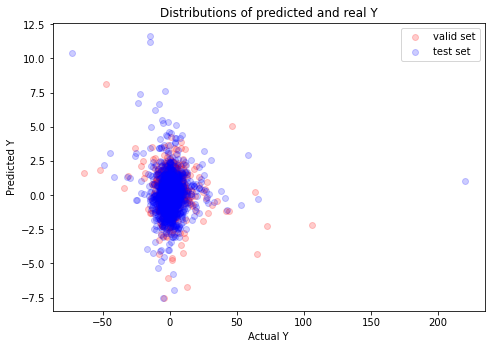

In [ ]:
##### Direct Linear Modling on Original Data 
model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_window_size_15, y_train_window_size_15)
get_cv_scores(model_lr, X_train_window_size_15, y_train_window_size_15)
evaluate_valid(model_lr, X_valid_window_size_15, y_valid_window_size_15, X_test_window_size_15, y_test_window_size_15)
print('Independent term in the linear model: ', model_lr.intercept_)
print('Estimated coefficients in the linear regression: ', model_lr.coef_)

CV Mean of R2:  -34.142026164049945
CV STD of R2:  61.29547302938725
Validation MAE: 5.110965287670247
Validation R2: -0.993458636226126
Test MAE: 4.799108920239202
Test R2: -1.482484212931082


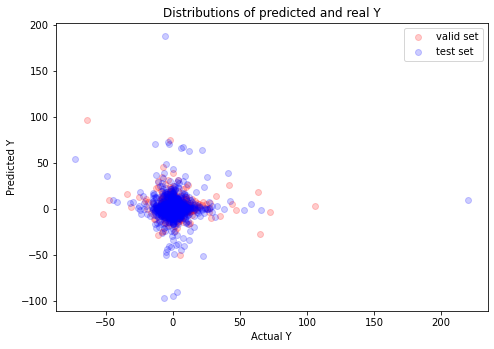

In [ ]:
##### Polynomial Regression (Degree=2) 
# Transformation of X_train/valid/test
polynomial_features= PolynomialFeatures(degree=2)
X_train_15_poly = polynomial_features.fit_transform(X_train_window_size_15)
X_valid_15_poly = polynomial_features.fit_transform(X_valid_window_size_15)
X_test_15_poly = polynomial_features.fit_transform(X_test_window_size_15)

# Model Fitting & Results
model_lr = LinearRegression(normalize=True, copy_X=True, n_jobs=100)
model_lr.fit(X_train_15_poly, y_train_window_size_15)
get_cv_scores(model_lr, X_train_15_poly, y_train_window_size_15)
evaluate_valid(model_lr, X_valid_15_poly, y_valid_window_size_15, X_test_15_poly, y_test_window_size_15)

## ARIMA

## RandomForrest Regressor
#### Still need to convert the time-related columns back to their original values

In [ ]:
rfmodel = RandomForestRegressor(random_state=142, 
                                criterion='mae',
                                n_jobs=4)

param_grid = {'max_depth': [10, 12],
              'n_estimators': [200, 500]}

rfmodel = cross_validation_training(rfmodel, X_train_window_size_15, 
                                    y_train_window_size_15, param_grid)

In [ ]:
result = evaluate_model(rfmodel, X_test_window_size_15, y_test_window_size_15)

## Gradient Boosting on Decision Trees (CatBoost and XGB)

### XGBoost Model

In [ ]:
dmatrix_train = xgb.DMatrix(data=X_train_window_size_15,label=y_train_window_size_15) 
dmatrix_valid = xgb.DMatrix(data=X_valid_window_size_15,label=y_valid_window_size_15)
dmatrix_test = xgb.DMatrix(data=X_test_window_size_15,label=y_test_window_size_15)

In [ ]:
params = {'objective': 'reg:linear', 'eval_metric': 'mae', 'n_estimators': 100}
evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]
xg_reg = xgb.train(params = params, dtrain=dmatrix_train, num_boost_round=8, evals=evallist)

[18:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:3.54028	train-mae:2.29256
[1]	eval-mae:3.54002	train-mae:2.2696
[2]	eval-mae:3.5481	train-mae:2.24682
[3]	eval-mae:3.54513	train-mae:2.23499
[4]	eval-mae:3.55618	train-mae:2.21956
[5]	eval-mae:3.56061	train-mae:2.21326
[6]	eval-mae:3.55525	train-mae:2.20124
[7]	eval-mae:3.55444	train-mae:2.19569


In [ ]:
result = evaluate_model(xg_reg, dmatrix_test, dmatrix_test.get_label())

Root mean squared error on test: 3.057834


### CatBoost Regressor Model

In [ ]:
model = CatBoostRegressor(loss_function='MAE', depth=2, learning_rate=0.001, iterations=1000, od_type='Iter', od_wait=10)
cat_features_ = ['dlvry_weekday', 'dlvry_hour', 'lasttrade_weekday', 'lasttrade_hour']
model.fit(
            X_train_window_size_15_tree, y_train_window_size_15,
            cat_features = cat_features_,
            use_best_model=True,
            eval_set=(X_valid_window_size_15_tree, y_valid_window_size_15),
        )

0:	learn: 2.2779859	test: 3.4704148	best: 3.4704148 (0)	total: 68.2ms	remaining: 1m 8s
1:	learn: 2.2779791	test: 3.4704124	best: 3.4704124 (1)	total: 91.7ms	remaining: 45.7s
2:	learn: 2.2779718	test: 3.4704078	best: 3.4704078 (2)	total: 111ms	remaining: 36.8s
3:	learn: 2.2779647	test: 3.4704061	best: 3.4704061 (3)	total: 133ms	remaining: 33.1s
4:	learn: 2.2779573	test: 3.4704042	best: 3.4704042 (4)	total: 152ms	remaining: 30.2s
5:	learn: 2.2779500	test: 3.4704029	best: 3.4704029 (5)	total: 171ms	remaining: 28.3s
6:	learn: 2.2779415	test: 3.4703953	best: 3.4703953 (6)	total: 192ms	remaining: 27.2s
7:	learn: 2.2779288	test: 3.4703900	best: 3.4703900 (7)	total: 214ms	remaining: 26.6s
8:	learn: 2.2779217	test: 3.4703853	best: 3.4703853 (8)	total: 234ms	remaining: 25.8s
9:	learn: 2.2779152	test: 3.4703837	best: 3.4703837 (9)	total: 254ms	remaining: 25.1s
10:	learn: 2.2779085	test: 3.4703832	best: 3.4703832 (10)	total: 276ms	remaining: 24.8s
11:	learn: 2.2779006	test: 3.4703812	best: 3.47038

In [ ]:
result = evaluate_model(model, X_test_window_size_15_tree, y_test_window_size_15)

Root mean squared error on test: 3.0058098490260847


### LightGBM Model

In [ ]:
train_data = lgb.Dataset(X_train_window_size_15_tree, label=y_train_window_size_15)
valid_data = lgb.Dataset(X_valid_window_size_15_tree, label=y_valid_window_size_15)
test_data = lgb.Dataset(X_test_window_size_15_tree, label=y_test_window_size_15)

In [ ]:
param = {'num_leaves': 100, 'objective': 'regression_l1', 'metric': 'mae'}
num_round = 20
bst = lgb.train(param, train_data, num_round, valid_sets=[valid_data])

[1]	valid_0's l1: 3.46952
[2]	valid_0's l1: 3.46835
[3]	valid_0's l1: 3.46626
[4]	valid_0's l1: 3.4634
[5]	valid_0's l1: 3.46418
[6]	valid_0's l1: 3.46432
[7]	valid_0's l1: 3.46815
[8]	valid_0's l1: 3.47019
[9]	valid_0's l1: 3.47218
[10]	valid_0's l1: 3.47187
[11]	valid_0's l1: 3.47067
[12]	valid_0's l1: 3.46986
[13]	valid_0's l1: 3.47057
[14]	valid_0's l1: 3.47019
[15]	valid_0's l1: 3.46769
[16]	valid_0's l1: 3.46854
[17]	valid_0's l1: 3.46904
[18]	valid_0's l1: 3.47179
[19]	valid_0's l1: 3.47385
[20]	valid_0's l1: 3.47668


In [ ]:
result = evaluate_model(bst, X_test_window_size_15_tree, y_test_window_size_15)

Root mean squared error on test: 3.014556784511605


## Support Vector Machine Regression

In [ ]:
svrmodel = SVR()

param_grid = {'kernel': ['rbf', 'poly'],
              'C': [10, 20]}

svrmodel = cross_validation_training(svrmodel, X_train_window_size_15, 
                                     y_train_window_size_15, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed: 30.3min remaining: 121.4min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 31.7min remaining: 25.9min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 54.3min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 54.8min finished


The best combination of parameters is {'C': 20, 'kernel': 'poly'}


In [ ]:
result = evaluate_model(svrmodel, X_test_window_size_15, y_test_window_size_15)

Root mean squared error on test: 3.010475956632053


## K-Nearest Neighbours

The optimal k was found doing a grid search for `range(3, 25)`.  

For this 'classic' approach, the train and valid set will be put together to make use of cross-validation.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X_train_window_size_15_classic = X_train_window_size_15.copy().append(X_valid_window_size_15)
y_train_window_size_15_classic = y_train_window_size_15.copy().append(y_valid_window_size_15)

minmax_transformer_classic = Pipeline(steps=[
        ('minmax', MinMaxScaler())])

preprocessor_window_size_15_classic = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer_classic , [X_train_window_size_15_classic.columns[1], *[*X_train_window_size_15_classic.columns[17:]]])
        ])


preprocessor_window_size_15_classic.fit(X_train_window_size_15, y_train_window_size_15)
X_train_window_size_15_classic_norm = preprocessor_window_size_15_classic.transform(X_train_window_size_15_classic)
X_test_window_size_15_classic_norm = preprocessor_window_size_15_classic.transform(X_test_window_size_15)

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor

class Knn:

    def __init__(self,
                 X_train: pd.DataFrame,
                 X_test: pd.DataFrame,
                 y_train: pd.DataFrame,
                 y_test: pd.DataFrame,
                 k: int):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.k = k
        self.model = KNeighborsRegressor(n_neighbors=self.k, n_jobs=-1)
        self.mae_scorer = make_scorer(mean_absolute_error)
    
    def get_cv_scores(self):
        return cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring=self.mae_scorer)

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        predictions = self.model.predict(self.X_test)
        return predictions

    def go(self):
        cv_scores = self.get_cv_scores()
        self.fit()
        predictions = self.predict()
        return cv_scores, predictions, self.model

In [19]:
knn_15 = Knn(
    X_train_window_size_15_classic_norm,
    X_test_window_size_15_classic_norm,
    y_train_window_size_15_classic,
    y_test_window_size_15,
    k=3
)

knn_cv_scores_15, knn_predictions_15, knn_model_15 = knn_15.go()

CV Scores for KNN

In [20]:
knn_cv_scores_15

array([2.59596059, 2.8094041 , 2.61839585, 2.74942573, 3.14400191])

Prediction Scores for KNN

In [21]:
knn_predictions_15

array([[ 4.17      ],
       [ 1.85666667],
       [-2.44333333],
       ...,
       [ 0.45      ],
       [-1.63333333],
       [-2.52333333]])

# Creating Deep Learning Models

## Preprocessing the data to 3D for Recurrent Neural Networks

In [ ]:
def unflatten_ohlcv(data, window_size):
  """Return 3D data for open, high, low, close and volume (ohlcv) 
  to make the data suitable for recurrent neural networks
  
  Arguments:
  data -- input data
  window_size -- 5 or 15 depending on dataset
  """

  if window_size == 5:
    # only keep open, high, low, close and volume features
    X = data.iloc[:,17:] 
    # drop minutes left feature as it is a linear function of time
    X = X.drop(["5", "11", "17", "23"], axis = 1)
    # apply MinMax scaling
    mmscaler = MinMaxScaler()
    X[X.columns] = mmscaler.fit_transform(X[X.columns])
    # give meaningful names to columns
    X = X.rename(columns={"0": "open_t-4", "1": "high_t-4", "2": "low_t-4",
                          "3": "close_t-4", "4": "vol_t-4", "6": "open_t-3",
                          "7": "high_t-3", "8": "low_t-3", "9": "close_t-3",
                          "10": "vol_t-3",  "12": "open_t-2", "13": "high_t-2",
                          "14": "low_t-2", "15": "close_t-2", "16": "vol_t-2",
                          "18": "open_t-1", "19": "high_t-1", "20": "low_t-1",
                          "21": "close_t-1", "22": "vol_t-1"})
    
    # separate data per feature
    X_open = X[["open_t-4", "open_t-3", "open_t-2", "open_t-1"]]
    X_high = X[["high_t-4", "high_t-3", "high_t-2", "high_t-1"]]
    X_low = X[["low_t-4", "low_t-3", "low_t-2", "low_t-1"]]
    X_close = X[["close_t-4", "close_t-3", "close_t-2", "close_t-1"]]
    X_vol = X[["vol_t-4", "vol_t-3", "vol_t-2", "vol_t-1"]]

    # stack data
    X = np.stack([X_open, X_high, X_low, X_close, X_vol], axis = 2)

    return X
      
  if window_size == 15:
    # only keep open, high, low, close and volume features
    X = data.iloc[:,17:] 
    # drop minutes left feature as it is a linear function of time
    X = X.drop(["5", "11", "17", "23", "29", "35", "41", "47", "53", "59", "65",
                "71", "77", "83"], axis = 1)
    # apply MinMax scaling
    mmscaler = MinMaxScaler()
    X[X.columns] = mmscaler.fit_transform(X[X.columns])
    # give meaningful names to columns
    X = X.rename(columns={"0": "open_t-14", "1": "high_t-14", "2": "low_t-14",
                          "3": "close_t-14", "4": "vol_t-14", "6": "open_t-13",
                          "7": "high_t-13", "8": "low_t-13", "9": "close_t-13",
                          "10": "vol_t-13", "12": "open_t-12", "13": "high_t-12",
                          "14": "low_t-12", "15": "close_t-12", "16": "vol_t-12",
                          "18": "open_t-11", "19": "high_t-11", "20": "low_t-11",
                          "21": "close_t-11", "22": "vol_t-11", "24": "open_t-10",
                          "25": "high_t-10", "26": "low_t-10", "27": "close_t-10",
                          "28": "vol_t-10", "30": "open_t-9", "31": "high_t-9",
                          "32": "low_t-9", "33": "close_t-9", "34": "vol_t-9",
                          "36": "open_t-8", "37": "high_t-8", "38": "low_t-8",
                          "39": "close_t-8", "40": "vol_t-8", "42": "open_t-7",
                          "43": "high_t-7", "44": "low_t-7", "45": "close_t-7",
                          "46": "vol_t-7", "48": "open_t-6", "49": "high_t-6",
                          "50": "low_t-6", "51": "close_t-6", "52": "vol_t-6",
                          "54": "open_t-5", "55": "high_t-5", "56": "low_t-5",
                          "57": "close_t-5", "58": "vol_t-5", "60": "open_t-4",
                          "61": "high_t-4", "62": "low_t-4", "63": "close_t-4",
                          "64": "vol_t-4", "66": "open_t-3", "67": "high_t-3",
                          "68": "low_t-3", "69": "close_t-3", "70": "vol_t-3",
                          "72": "open_t-2", "73": "high_t-2", "74": "low_t-2",
                          "75": "close_t-2", "76": "vol_t-2", "78": "open_t-1",
                          "79": "high_t-1", "80": "low_t-1", "81": "close_t-1",
                          "82": "vol_t-1"})

    # separate data per feature
    X_open = X[["open_t-14", "open_t-13", "open_t-12", "open_t-11", "open_t-10",
                "open_t-9", "open_t-8", "open_t-7", "open_t-6", "open_t-5",
                "open_t-4", "open_t-3", "open_t-2", "open_t-1"]]
    X_high = X[["high_t-14", "high_t-13", "high_t-12", "high_t-11", "high_t-10",
                "high_t-9", "high_t-8", "high_t-7", "high_t-6", "high_t-5",
                "high_t-4", "high_t-3", "high_t-2", "high_t-1"]]
    X_low = X[["low_t-14", "low_t-13", "low_t-12", "low_t-11", "low_t-10",
               "low_t-9", "low_t-8", "low_t-7", "low_t-6", "low_t-5", "low_t-4",
               "low_t-3", "low_t-2", "low_t-1"]]
    X_close = X[["close_t-14", "close_t-13", "close_t-12", "close_t-11",
                 "close_t-10", "close_t-9", "close_t-8", "close_t-7",
                 "close_t-6", "close_t-5", "close_t-4", "close_t-3",
                 "close_t-2", "close_t-1"]]
    X_vol = X[["vol_t-14", "vol_t-13", "vol_t-12", "vol_t-11", "vol_t-10",
               "vol_t-9", "vol_t-8", "vol_t-7", "vol_t-6", "vol_t-5",
               "vol_t-4", "vol_t-3", "vol_t-2", "vol_t-1"]]

    # stack data
    X = np.stack([X_open, X_high, X_low, X_close, X_vol], axis = 2)

    return X

## Mulit-Layer Perceptron

### Takeaway
For the MLP, the architecture seemed to be rather irrelevant. Generally speaking, simpler architectures with less neurons seemed to work as well as more complex architectures with several hidden layers and/or a large number of neurons. In total, a few hundred neurons overall were enough. Dropout, LR Scheduling and Adam optimizer created the best results.  
We also found that higher batch sizes decreased the MAE.  
One interesting finding is that the performance on the validation set would not change after 2-3 epochs. Additionally, the performance on the test set was always better than the performance on the validation set.

In [22]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.math import exp
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


class Mlp:
    """
    Creates a multilayer-perceptron model.
    """
    def __init__(self, 
                 X_train: pd.DataFrame, 
                 X_valid: pd.DataFrame, 
                 X_test: pd.DataFrame, 
                 y_train: pd.DataFrame, 
                 y_valid: pd.DataFrame, 
                 y_test: pd.DataFrame, 
                 params: dict, 
                 layers: list, 
                 dropout: bool,
                 schedulerthresh: int,
                 optimizer,
                 earlystopping: int
                 ):
        self.X_train = X_train
        self.X_valid = X_valid
        self.X_test = X_test
        self.y_train = y_train
        self.y_valid = y_valid
        self.y_test = y_test
        self.params = params
        self.layers = layers
        self.dropout = dropout
        self.schedulerthresh = schedulerthresh
        self.optimizer = optimizer
        self.earlystopping = earlystopping
        self.model = Sequential()

    def compile_model(self):
        be.clear_session()
        self.model.add(Input(shape=(self.X_train.shape[1])))
        for i in range(len(self.layers)):
            self.model.add(Dense(self.layers[i], activation="relu"))
            if self.dropout:
                self.model.add(Dropout(rate=self.dropout))
        self.model.add(Dense(1, activation="linear"))
        optimizer = self.optimizer
        self.model.compile(loss='mean_absolute_error', optimizer=optimizer)
        return self.model
        
    def fit_model(self):
        callbacks = []
        if self.scheduler:
            callbacks.append(LearningRateScheduler(self.scheduler))
        if self.earlystopping:
            callbacks.append(EarlyStopping(monitor='loss', patience=self.earlystopping))
        history = self.model.fit(x=self.X_train,y=self.y_train, batch_size=self.params["BATCH_SIZE"], validation_data=(self.X_valid,self.y_valid), epochs=self.params["EPOCHS"], callbacks=callbacks, verbose=1, shuffle=False)
        return history, self.model

    def evaluate_model(self):
        eval_score = self.model.evaluate(self.X_test, self.y_test.to_numpy())
        return eval_score, self.model

    def predict(self):
        return self.model.predict(self.X_test)
      
    def go(self):
        self.compile_model()
        history, _ = self.fit_model()
        eval_score, _ = self.evaluate_model()
        predictions = self.predict()
        return history, eval_score, predictions, self.model
        
    def scheduler(self, epoch, lr):
        if self.schedulerthresh:
            thresh = self.schedulerthresh
        else:
            thresh = 5
        if epoch < thresh:
            return lr
        else:
          return lr*exp(-0.1)


### Creating best model for MLP

In [23]:
params = {
    "BATCH_SIZE": 2048, 
    "EPOCHS": 10, 
    "LEARNING_RATE": 0.0005}
layers = [300, 100]
dropout = 0.25
scheduler = 5
optimizer = Adam(learning_rate=0.0005)
earlystopping = 3

mlp_15 = Mlp(
    X_train_window_size_15,
    X_valid_window_size_15,
    X_test_window_size_15,
    y_train_window_size_15,
    y_valid_window_size_15,
    y_test_window_size_15,
    params,
    layers,
    dropout,
    scheduler,
    optimizer,
    earlystopping
)
mlp_history_15, mlp_eval_score_15, mlp_predictions_15, mlp_model_15 = mlp_15.go()

Epoch 1/10
15/15 [==============================] - 2s 53ms/step - loss: 2.4707 - val_loss: 3.4778
Epoch 2/10
15/15 [==============================] - 1s 35ms/step - loss: 2.3331 - val_loss: 3.4681
Epoch 3/10
15/15 [==============================] - 1s 37ms/step - loss: 2.3022 - val_loss: 3.4678
Epoch 4/10
15/15 [==============================] - 1s 35ms/step - loss: 2.2906 - val_loss: 3.4699
Epoch 5/10
15/15 [==============================] - 1s 34ms/step - loss: 2.2848 - val_loss: 3.4701
Epoch 6/10
15/15 [==============================] - 1s 34ms/step - loss: 2.2837 - val_loss: 3.4705
Epoch 7/10
15/15 [==============================] - 0s 33ms/step - loss: 2.2831 - val_loss: 3.4706
Epoch 8/10
15/15 [==============================] - 1s 35ms/step - loss: 2.2802 - val_loss: 3.4718
Epoch 9/10
15/15 [==============================] - 1s 34ms/step - loss: 2.2808 - val_loss: 3.4718
Epoch 10/10
110/110 [==============================] - 0s 2ms/step - loss: 3.0087


Evaluation Score of MLP

In [24]:
mlp_eval_score_15

3.008734941482544

Plotting the Convergence process

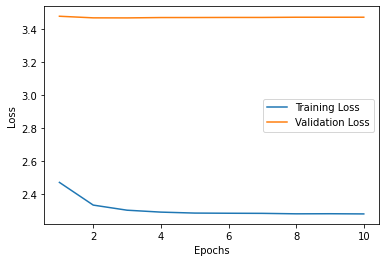

In [25]:
import matplotlib.pyplot as plt

loss_values = mlp_history_15.history['loss']
val_loss_values = mlp_history_15.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Convolutional Neural Network

## Recurrent Neural Network

### LSTM: Long-Short-Term Memory

### Gated recurrent unit

## Transformers: Attention is all you need!